# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group and generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/wenbo/Desktop/tongxue
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 26, 6, 53, 7, 696613)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-26 06:53:07,701 INFO: Initializing external client
2025-11-26 06:53:07,701 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-26 06:53:08,349 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-26 06:53:09,184 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1303706


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-26 06:53:14,003 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/502379 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111095 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19783 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/6148 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/6148 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='7.724786E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-28 00:00:00+00:00,8.55,0.0,8.089993,147.724380,shanghai
1,2025-12-01 00:00:00+00:00,10.30,0.0,7.517021,73.300674,shanghai
2,2025-11-30 00:00:00+00:00,15.25,0.0,11.681987,326.309906,shanghai
3,2025-11-29 00:00:00+00:00,13.45,0.0,9.360001,157.380096,shanghai
4,2025-12-02 00:00:00+00:00,13.25,0.0,9.957108,130.601212,shanghai
5,2025-11-27 00:00:00+00:00,7.90,0.0,9.178235,311.820068,shanghai


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-28 00:00:00+00:00,8.55,0.0,8.089993,147.724380,shanghai,82.138916
1,2025-12-01 00:00:00+00:00,10.30,0.0,7.517021,73.300674,shanghai,134.306946
2,2025-11-30 00:00:00+00:00,15.25,0.0,11.681987,326.309906,shanghai,87.769363
3,2025-11-29 00:00:00+00:00,13.45,0.0,9.360001,157.380096,shanghai,75.719467
4,2025-12-02 00:00:00+00:00,13.25,0.0,9.957108,130.601212,shanghai,74.026611
5,2025-11-27 00:00:00+00:00,7.90,0.0,9.178235,311.820068,shanghai,104.388016


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 344.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
5,2025-11-27 00:00:00+00:00,7.90,0.0,9.178235,311.820068,shanghai,104.388016,pudonghuinan,china,6
0,2025-11-28 00:00:00+00:00,8.55,0.0,8.089993,147.724380,shanghai,82.138916,pudonghuinan,china,1
3,2025-11-29 00:00:00+00:00,13.45,0.0,9.360001,157.380096,shanghai,75.719467,pudonghuinan,china,4
2,2025-11-30 00:00:00+00:00,15.25,0.0,11.681987,326.309906,shanghai,87.769363,pudonghuinan,china,3
1,2025-12-01 00:00:00+00:00,10.30,0.0,7.517021,73.300674,shanghai,134.306946,pudonghuinan,china,2
4,2025-12-02 00:00:00+00:00,13.25,0.0,9.957108,130.601212,shanghai,74.026611,pudonghuinan,china,5


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 5 to 4
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
 7   street                       6 non-null      object                 
 8   country                      6 non-null      object                 
 9   days_before_forecast_day     6 non-null      int64                  
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-26 06:53:21,621 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



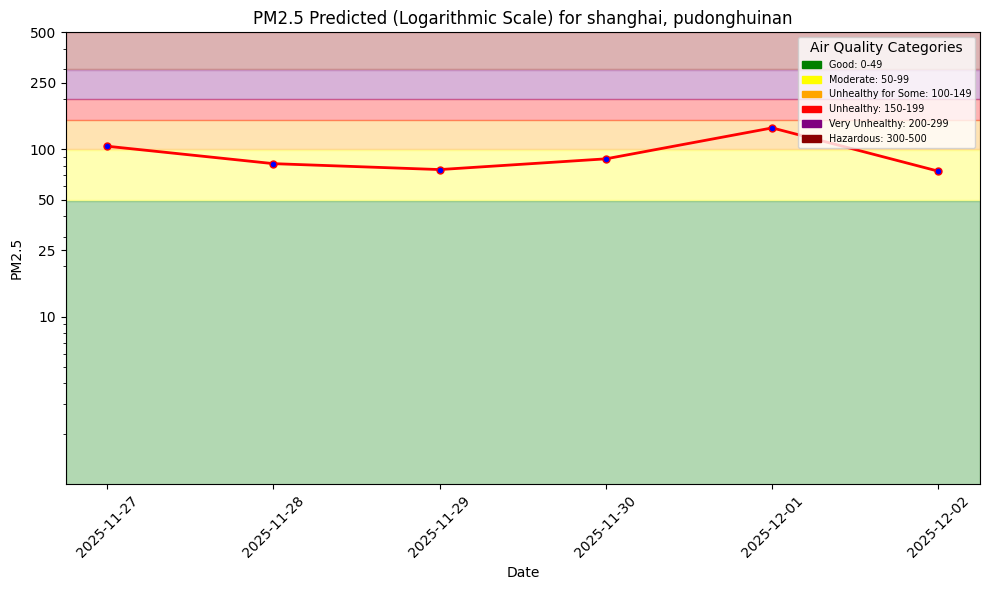

In [12]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [14]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1303706/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-26 06:53:39,386 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-26 06:53:42,568 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-26 06:55:15,311 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-26 06:55:15,482 INFO: Waiting for log aggregation to finish.
2025-11-26 06:55:24,143 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [15]:
test_df=monitor_fg.read()
test_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.16s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-28 00:00:00+00:00,8.55,0.0,8.089993,147.724380,shanghai,82.138916,pudonghuinan,china,1
1,2025-12-02 00:00:00+00:00,13.25,0.0,9.957108,130.601212,shanghai,74.026611,pudonghuinan,china,5
2,2025-11-27 00:00:00+00:00,7.90,0.0,9.178235,311.820068,shanghai,104.388016,pudonghuinan,china,6
3,2025-11-30 00:00:00+00:00,15.25,0.0,11.681987,326.309906,shanghai,87.769363,pudonghuinan,china,3
4,2025-11-29 00:00:00+00:00,13.45,0.0,9.360001,157.380096,shanghai,75.719467,pudonghuinan,china,4
5,2025-12-01 00:00:00+00:00,10.30,0.0,7.517021,73.300674,shanghai,134.306946,pudonghuinan,china,2
6,2025-11-26 00:00:00+00:00,9.90,0.0,8.049845,169.695206,shanghai,130.516998,pudonghuinan,china,1


In [16]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.71s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-28 00:00:00+00:00,8.55,0.0,8.089993,147.724380,shanghai,82.138916,pudonghuinan,china,1
1,2025-11-26 00:00:00+00:00,9.90,0.0,8.049845,169.695206,shanghai,130.516998,pudonghuinan,china,1


In [17]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.26s) 


,date,pm25,country,city,street,url
0,2018-09-17 00:00:00+00:00,30.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186
1,2021-07-04 00:00:00+00:00,68.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186
2,2019-06-24 00:00:00+00:00,61.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186
3,2021-09-18 00:00:00+00:00,62.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186
4,2019-06-18 00:00:00+00:00,54.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186
...,...,...,...,...,...,...
2538,2019-02-08 00:00:00+00:00,39.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186
2539,2024-04-22 00:00:00+00:00,61.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186
2540,2022-06-30 00:00:00+00:00,29.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186
2541,2025-05-12 00:00:00+00:00,96.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186


In [18]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]
print(outcome_df)
print(preds_df)


                          date  pm25
0    2018-09-17 00:00:00+00:00  30.0
1    2021-07-04 00:00:00+00:00  68.0
2    2019-06-24 00:00:00+00:00  61.0
3    2021-09-18 00:00:00+00:00  62.0
4    2019-06-18 00:00:00+00:00  54.0
...                        ...   ...
2538 2019-02-08 00:00:00+00:00  39.0
2539 2024-04-22 00:00:00+00:00  61.0
2540 2022-06-30 00:00:00+00:00  29.0
2541 2025-05-12 00:00:00+00:00  96.0
2542 2025-11-26 00:00:00+00:00  82.0

[2543 rows x 2 columns]
                       date  predicted_pm25
0 2025-11-28 00:00:00+00:00       82.138916
1 2025-11-26 00:00:00+00:00      130.516998


In [19]:
hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2025-11-26 00:00:00+00:00,130.516998,82.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

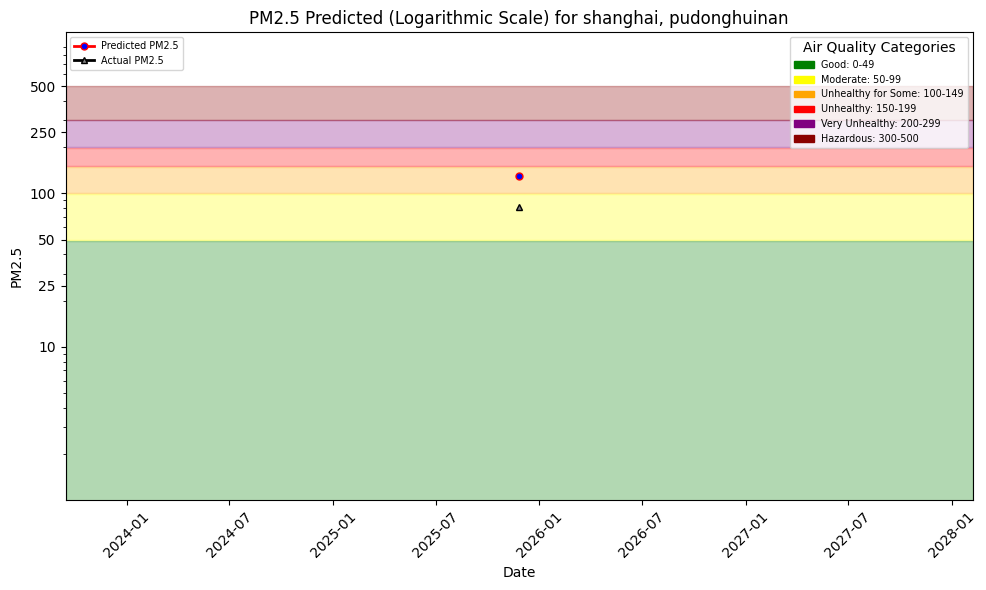

In [20]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [21]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/wenbo/Desktop/tongxue/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|          | 0/443…

Uploading /Users/wenbo/Desktop/tongxue/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|          | …

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1303706/settings/fb/path/Resources/airquality


---

### Grade ‘C’ tasks

In [22]:
# Import the XGBRegressor class from the XGBoost library
from xgboost import XGBRegressor

# Get the model registry from the current project
mr = project.get_model_registry()

# Retrieve a specific version of a model from the registry
lag_model = mr.get_model(
    name="air_quality_xgboost_model_C",  # Name of the model
    version=1,                           # Specific version of the model to retrieve
)

# Access the feature view associated with the retrieved model
feature_view_v2 = lag_model.get_feature_view()

# Download the saved model files to a local directory
lag_saved_model_dir = lag_model.download()

# Initialize a new XGBRegressor instance
retrieved_xgboost_model_C = XGBRegressor()

# Load the model parameters from the downloaded JSON file
retrieved_xgboost_model_C.load_model(lag_saved_model_dir + "/model.json")

# Display the loaded XGBoost model object
retrieved_xgboost_model_C


2025-11-26 06:55:39,316 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/491863 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/113603 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26603 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/6148 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/6148 elapsed<00:00 remaining<?

XGBRegressor(base_score='7.729354E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
air_quality_fg_v2 = fs.get_feature_group(
    name="air_quality",
    version=2,
)
air_quality_df_v2=air_quality_fg_v2.read().sort_values("date")
batch_data_v2 = air_quality_fg_v2.filter(air_quality_fg_v2.date >= today).read()
batch_data_v2


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.22s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.61s) 


,date,pm25,country,city,street,url,pm25_lag1,pm25_lag2,pm25_lag3


In [24]:
batch_data_v2 = air_quality_fg_v2.filter(air_quality_fg_v2.date >= today).read()
batch_data_v2

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 


,date,pm25,country,city,street,url,pm25_lag1,pm25_lag2,pm25_lag3


In [25]:
import pandas as pd

# Retrieve version 2 of the 'air_quality' feature group from the feature store
air_quality_fg_v2 = fs.get_feature_group(
    name="air_quality",
    version=2,
)

# Read the feature group into a DataFrame and sort by date
aq_hist = air_quality_fg_v2.read().sort_values("date")

# Get the last 7 records (most recent week) from the air quality history
aq_hist_tail = aq_hist.tail(7)   

# Extract the PM2.5 values from the last 7 days as a list
pm25_history = list(aq_hist_tail["pm25"].values)


# Retrieve version 1 of the 'weather' feature group from the feature store
weather_fg = fs.get_feature_group(
    name="weather",
    version=1,
)

# Filter the weather data to include only future dates from today
weather_future = weather_fg.filter(weather_fg.date >= today).read()

# Sort the future weather data by date
weather_future = weather_future.sort_values("date")


# Define the features to be used for the PM2.5 prediction model
feature_cols_C = [
    "pm25_lag1",  # PM2.5 from 1 day ago
    "pm25_lag2",  # PM2.5 from 2 days ago
    "pm25_lag3",  # PM2.5 from 3 days ago
    "temperature_2m_mean",
    "precipitation_sum",
    "wind_speed_10m_max",
    "wind_direction_10m_dominant",
]

# Initialize a list to store forecasted rows
forecast_rows = []

# Iterate over each row in the future weather data to make PM2.5 predictions
for _, row in weather_future.iterrows():
    # Generate lag features for PM2.5
    if len(pm25_history) < 3:
        # If less than 3 historical values, repeat the last available value
        pm25_lag1 = pm25_history[-1]
        pm25_lag2 = pm25_history[-1]
        pm25_lag3 = pm25_history[-1]
    else:
        # Otherwise, use the last 3 PM2.5 values as lag features
        pm25_lag1 = pm25_history[-1]
        pm25_lag2 = pm25_history[-2]
        pm25_lag3 = pm25_history[-3]

    # Create a dictionary with all features for the current forecast day
    feature_row = {
        "pm25_lag1": pm25_lag1,
        "pm25_lag2": pm25_lag2,
        "pm25_lag3": pm25_lag3,
        "temperature_2m_mean": row["temperature_2m_mean"],
        "precipitation_sum": row["precipitation_sum"],
        "wind_speed_10m_max": row["wind_speed_10m_max"],
        "wind_direction_10m_dominant": row["wind_direction_10m_dominant"],
    }

    # Convert the dictionary into a DataFrame and select only the relevant feature columns
    X_row = pd.DataFrame([feature_row])[feature_cols_C]

    # Use the pre-trained XGBoost model to predict PM2.5 for this day
    y_pred = retrieved_xgboost_model_C.predict(X_row)[0]

    # Append the predicted PM2.5 to the history for use in the next iteration
    pm25_history.append(y_pred)

    # Store the predicted value and corresponding date
    forecast_rows.append({
        "date": row["date"],
        "predicted_pm25": y_pred,
    })

# Convert the list of forecasted rows into a DataFrame
batch_data_C = pd.DataFrame(forecast_rows)

# Add metadata columns
batch_data_C["street"] = street
batch_data_C["city"] = city
batch_data_C["country"] = country

# Add a column indicating the number of days before the forecast day
batch_data_C["days_before_forecast_day"] = range(1, len(batch_data_C) + 1)

# Sort the DataFrame by date
batch_data_C = batch_data_C.sort_values(by=["date"])

# Display the final forecast DataFrame
batch_data_C


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.60s) 


,date,predicted_pm25,street,city,country,days_before_forecast_day
0,2025-11-27 00:00:00+00:00,92.223885,pudonghuinan,shanghai,china,1
1,2025-11-28 00:00:00+00:00,73.089447,pudonghuinan,shanghai,china,2
2,2025-11-29 00:00:00+00:00,73.362671,pudonghuinan,shanghai,china,3
3,2025-11-30 00:00:00+00:00,100.763985,pudonghuinan,shanghai,china,4
4,2025-12-01 00:00:00+00:00,120.625900,pudonghuinan,shanghai,china,5
5,2025-12-02 00:00:00+00:00,131.571976,pudonghuinan,shanghai,china,6


In [26]:
monitor_fg_c = fs.get_or_create_feature_group(
    name='aq_predictions_c',   
    description='Air quality prediction monitoring (lag model c)',
    version=1,
    primary_key=['city', 'street', 'date', 'days_before_forecast_day'],
    event_time="date",
)

monitor_fg_c.insert(batch_data_C, wait=True)


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:00 | Remaining Time


Launching job: aq_predictions_c_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1303706/jobs/named/aq_predictions_c_1_offline_fg_materialization/executions
2025-11-26 06:56:09,972 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-26 06:56:13,154 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-26 06:57:42,599 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-26 06:57:42,764 INFO: Waiting for log aggregation to finish.
2025-11-26 06:58:01,613 INFO: Execution finished successfully.


(Job('aq_predictions_c_1_offline_fg_materialization', 'SPARK'), None)

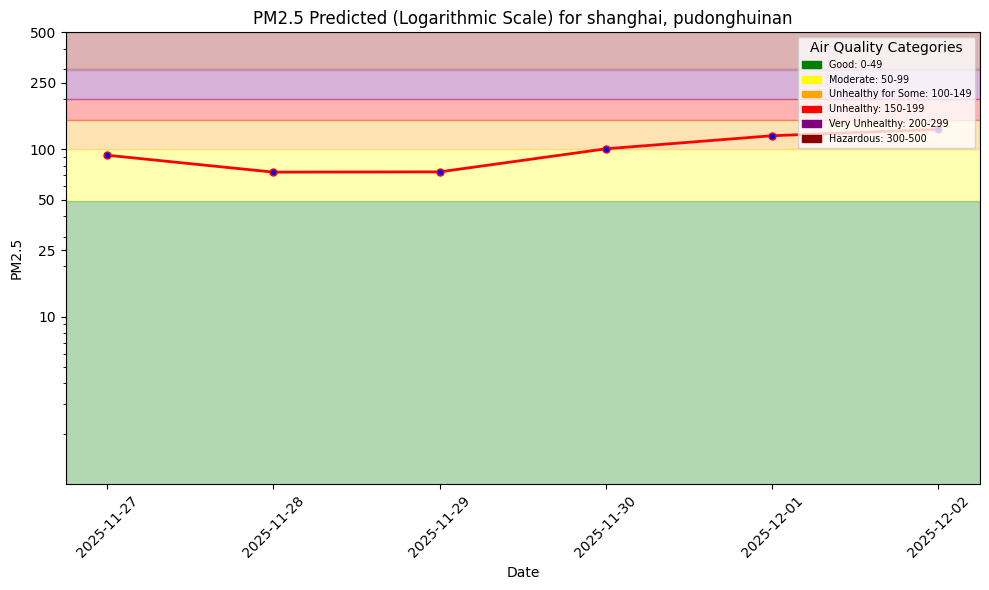

In [27]:
# === Draw the prediction graph of the lag model ===
pred_file_path_C = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_C.png"

plt = util.plot_air_quality_forecast(
    city,
    street,
    batch_data_C,
    pred_file_path_C,
)
plt.show()


In [28]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df_v2 = monitor_fg_c.filter(monitor_fg_c.days_before_forecast_day == 1).read()
monitoring_df_v2

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.15s) 


,date,predicted_pm25,street,city,country,days_before_forecast_day
0,2025-11-27 00:00:00+00:00,92.223885,pudonghuinan,shanghai,china,1


In [29]:
air_quality_df_v2=air_quality_fg_v2.read()
air_quality_df_v2

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 


,date,pm25,country,city,street,url,pm25_lag1,pm25_lag2,pm25_lag3
0,2018-09-17 00:00:00+00:00,30.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186,44.0,55.0,43.0
1,2021-07-04 00:00:00+00:00,68.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186,77.0,66.0,68.0
2,2019-06-24 00:00:00+00:00,61.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186,81.0,75.0,56.0
3,2019-06-18 00:00:00+00:00,54.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186,80.0,155.0,127.0
4,2021-09-18 00:00:00+00:00,62.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186,53.0,39.0,26.0
...,...,...,...,...,...,...,...,...,...
2535,2019-02-08 00:00:00+00:00,39.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186,79.0,106.0,62.0
2536,2024-04-22 00:00:00+00:00,61.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186,73.0,75.0,112.0
2537,2022-06-30 00:00:00+00:00,29.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186,42.0,41.0,37.0
2538,2025-05-12 00:00:00+00:00,96.0,china,shanghai,pudonghuinan,https://api.waqi.info/feed/@10186,84.0,95.0,61.0


In [30]:
outcome_df_v2 = air_quality_df_v2[['date', 'pm25']]
outcome_df_v2


,date,pm25
0,2018-09-17 00:00:00+00:00,30.0
1,2021-07-04 00:00:00+00:00,68.0
2,2019-06-24 00:00:00+00:00,61.0
3,2019-06-18 00:00:00+00:00,54.0
4,2021-09-18 00:00:00+00:00,62.0
...,...,...
2535,2019-02-08 00:00:00+00:00,39.0
2536,2024-04-22 00:00:00+00:00,61.0
2537,2022-06-30 00:00:00+00:00,29.0
2538,2025-05-12 00:00:00+00:00,96.0


In [31]:
outcome_df_v2 = air_quality_df_v2[['date', 'pm25']]
preds_df_v2 =  monitoring_df_v2[['date', 'predicted_pm25']]

hindcast_df_v2 = pd.merge(preds_df_v2, outcome_df_v2, on="date")
hindcast_df_v2 = hindcast_df_v2.sort_values(by=['date'])

hindcast_df_v2


,date,predicted_pm25,pm25


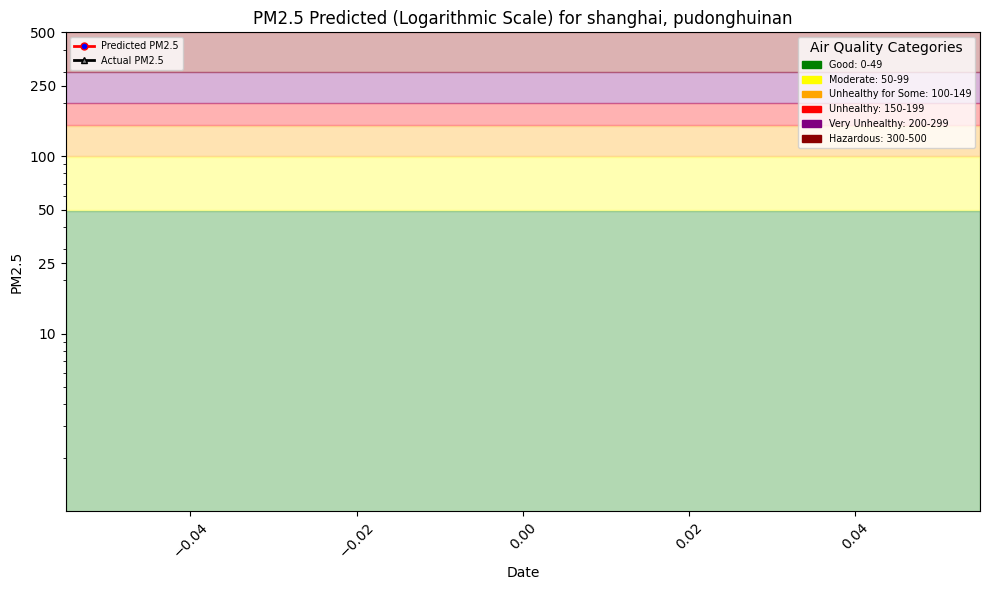

In [32]:
hindcast_file_path_v2 = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_v2.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df_v2, hindcast_file_path_v2, hindcast=True)
plt.show()